In [1]:
%run config.ipynb
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
import spacy
import re
import featuretools as ft

# Data Filtering

In [2]:
business = pd.read_json("data/yelp_academic_dataset_business.json", lines=True)
checkin = pd.read_json("data/yelp_academic_dataset_checkin.json", lines=True)
# review = pd.read_csv("data/yelp_academic_dataset_sample_review.csv")
review = pd.read_csv("data/yelp_academic_dataset_sample005_review.csv")
tip = pd.read_json("data/yelp_academic_dataset_tip.json", lines=True)
user = pd.read_json("data/yelp_academic_dataset_user.json", lines=True)

### For User

In [6]:
user.isnull().sum()

user_id               0
name                  0
review_count          0
yelping_since         0
useful                0
funny                 0
cool                  0
elite                 0
friends               0
fans                  0
average_stars         0
compliment_hot        0
compliment_more       0
compliment_profile    0
compliment_cute       0
compliment_list       0
compliment_note       0
compliment_plain      0
compliment_cool       0
compliment_funny      0
compliment_writer     0
compliment_photos     0
dtype: int64

It seems no missing value here

In [29]:
user["total_compliments"] = user["compliment_hot"] + user["compliment_more"] + user["compliment_profile"] + user["compliment_cute"] + \
                            user["compliment_list"] + user["compliment_note"] + user["compliment_plain"] + user["compliment_cool"] + \
                            user["compliment_funny"] + user["compliment_writer"] + user["compliment_photos"]
        
def num_year(data):
    return data.count(',') + 1 if data else 0
user["elite"] = user["elite"].apply(num_year)

user_filter = user[["user_id", "review_count", "elite", "friends", "fans", "average_stars", "total_compliments"]]
user_filter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1968703 entries, 0 to 1968702
Data columns (total 7 columns):
 #   Column             Dtype  
---  ------             -----  
 0   user_id            object 
 1   review_count       int64  
 2   elite              int64  
 3   friends            object 
 4   fans               int64  
 5   average_stars      float64
 6   total_compliments  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 105.1+ MB


### For Review

In [32]:
review.isnull().sum()

review_id                0
user_id                  0
business_id              0
stars                    0
useful                   0
funny                    0
cool                     0
text                     0
date                     0
text_after_cleaning    128
dtype: int64

In [35]:
review[review["text_after_cleaning"].isnull()]

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,text_after_cleaning
7760,kiUtkGN4wwhiiHzpLr87iQ,z9w399cBpCAKXhH_JA1AtQ,f6eYVrrILm5mcPqWKoMiHg,3,1,0,0,"Galleria韩国超市越开越多啦，除了uptown yonge st,开到downtown...",2017-09-21 02:21:02,NaN
15545,vbkFw-odUg2qmKaruttAZg,z9w399cBpCAKXhH_JA1AtQ,zEDzeZzGYSyg0DHurOv7yw,4,1,0,0,比较出名的大型装修用品连锁店，好多地区都有分店，从大件的木板或家具，到小小的零件配件制品，房...,2018-06-06 14:40:06,NaN
15656,6cbV6l5153ujkEHOkVdE0w,uUkYprg5GP-ExpexAP2s_g,cC9wi58GkVqWDHhc0rYxeQ,5,0,0,0,They are great with big dogs (Newfoundland) !,2011-12-03 01:33:38,NaN
20135,OVv88r8ivIwd5_QfDUErzQ,z9w399cBpCAKXhH_JA1AtQ,aEoNNQxqvbSnXv65GrhBeQ,5,2,0,0,听朋友讲Taro fish原是J-Town的鱼市场，后来摆左离sheappard呢个不显眼的...,2017-09-24 05:50:29,NaN
22574,Dpeg84lcYd776Ddc8CRVsg,guZajdPCJAPKOjoSCROjxA,iOtyjeDgW4hE25gKCwS8IQ,5,0,0,0,Richmond Hillにある中華料理屋さん。\n駐車場スペースが十分にあるモール内にあり...,2019-10-29 05:04:20,NaN
...,...,...,...,...,...,...,...,...,...,...
390714,kOm0zGlVv4uqXdRGifhkVA,mwQGpaorccJZvMFwEn4BsQ,3_tWe-D5if9y8RrmMrN7AQ,5,3,0,0,適正なお値段でちゃんとした美味しい日本料理を出してくれる、日本人の板さんによる日本食レストラ...,2016-01-27 00:23:13,NaN
392845,2zKgJ2GFW3FfByBBvDhidw,9zZu7qp693UyfaB-o1C6dg,lO2fIIZj225NIk5t2k69NA,5,0,0,0,來美國二十天，最好吃的中餐，口味十分接近香港。已成為我在Vegas 的飯堂！已經光顧不下十次...,2018-06-09 06:14:26,NaN
393201,TqMrXJp3LvovwO7M7R8JOQ,gOPm2yoe38_OM6x4NIwLEw,LYpujMCxfrHcSO_NA1BRQg,5,0,0,0,Low-key and friendly mimosa-and-quiche kind of...,2009-02-15 17:12:46,NaN
395207,1P8tpqlemFi7Kjg1shFFeA,ZZJT_M20GPXCDTRCjtC-VA,HtbGxP9QuXp3sWfPoXhbpA,5,0,0,0,Excellent restaurant. Le propriétaire est très...,2016-02-20 22:42:48,NaN


In [37]:
review.dropna(inplace=True)

This project is only study on English

In [38]:
review_filter = review[["review_id", "user_id", "business_id", "stars", "text"]]
review_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400928 entries, 0 to 401055
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   review_id            400928 non-null  object
 1   user_id              400928 non-null  object
 2   business_id          400928 non-null  object
 3   stars                400928 non-null  int64 
 4   text                 400928 non-null  object
 5   text_after_cleaning  400928 non-null  object
dtypes: int64(1), object(5)
memory usage: 21.4+ MB


### For Business

In [ ]:
business.info()

In [ ]:
business_filter = business[["business_id", "name", "categories"]]
business_filter["business_stars"] = business["stars"]
business_filter.info()

### Merging

In [52]:
user_filter.columns = [i if '_id' in i else 'user_'+i for i in user_filter.columns]
user_filter.columns

Index(['user_id', 'user_review_count', 'user_elite', 'user_friends',
       'user_fans', 'user_average_stars', 'user_total_compliments'],
      dtype='object')

In [55]:
review_filter.columns = [i if '_id' in i else 'review_'+i for i in review_filter.columns]
review_filter.columns

Index(['review_id', 'user_id', 'business_id', 'review_stars', 'review_text',
       'review_text_after_cleaning'],
      dtype='object')

In [57]:
business_filter.columns = [i if '_id' in i or 'business' in i else 'business_'+i for i in business_filter.columns]
business_filter.columns

Index(['business_id', 'business_name', 'business_categories',
       'business_stars'],
      dtype='object')

In [72]:
df = review_filter.merge(user_filter, on='user_id')

In [73]:
df = df.merge(business_filter, on='business_id')

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400928 entries, 0 to 400927
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   review_id                   400928 non-null  object 
 1   user_id                     400928 non-null  object 
 2   business_id                 400928 non-null  object 
 3   review_stars                400928 non-null  int64  
 4   review_text                 400928 non-null  object 
 5   review_text_after_cleaning  400928 non-null  object 
 6   user_review_count           400928 non-null  int64  
 7   user_elite                  400928 non-null  int64  
 8   user_friends                400928 non-null  object 
 9   user_fans                   400928 non-null  int64  
 10  user_average_stars          400928 non-null  float64
 11  user_total_compliments      400928 non-null  int64  
 12  business_name               400928 non-null  object 
 13  business_categ

In [75]:
df = df[~df["business_categories"].isnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400807 entries, 0 to 400927
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   review_id                   400807 non-null  object 
 1   user_id                     400807 non-null  object 
 2   business_id                 400807 non-null  object 
 3   review_stars                400807 non-null  int64  
 4   review_text                 400807 non-null  object 
 5   review_text_after_cleaning  400807 non-null  object 
 6   user_review_count           400807 non-null  int64  
 7   user_elite                  400807 non-null  int64  
 8   user_friends                400807 non-null  object 
 9   user_fans                   400807 non-null  int64  
 10  user_average_stars          400807 non-null  float64
 11  user_total_compliments      400807 non-null  int64  
 12  business_name               400807 non-null  object 
 13  business_categ

In [3]:
df.head(1)

,review_id,user_id,business_id,review_stars,review_text,review_text_after_cleaning,user_review_count,user_elite,user_friends,user_fans,user_average_stars,user_total_compliments,business_name,business_categories,business_stars
0,yNB39szX3M8mTEzTtsgoCw,Y1iCYGvLf4ifPoXlKLGq-w,o2Qh4SiGYJ7BK4hP7dfkrw,5,This is an amazing indian Bistro!!I If I do sa...,amaz bistroi say myself never cuisin glad expe...,1,0,None,0,5.0,0,Saffron Indian Bistro,"Restaurants, Indian",4.5


In [10]:
df.to_csv("data/yelp_academic_dataset_sample005_filter.csv", index=False)

# Preprocessing

In [2]:
df = pd.read_csv("data/yelp_academic_dataset_sample005_filter.csv")

### Text Cleaning

In [4]:
X = df["text"]
nlp = spacy.load("en_core_web_lg")
stop_words = set(stopwords.words('english')) 

In [5]:
SYMBOL_RE = re.compile('[/(){}\[\]\|@,.:!?;\-*]')
# website regex is from https://regexr.com/3e4a2
WEBSITES_RE = re.compile('(https?:\/\/)?(www\.)[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,4}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)| \
                         (https?:\/\/)?(www\.)?(?!ww)[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,4}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)')
ABBR_RE = re.compile('[a-z]*[\'][^ ]*')
def clean_text(text):
    text = text.lower()

    text = WEBSITES_RE.sub('', text)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    text = SYMBOL_RE.sub('', text)
    text = ABBR_RE.sub('', text)

    # remove entities as they are meaningless in most times
    for ent in nlp(text).ents:
        text = text.replace(str(ent), '')
        
    tokens = word_tokenize(text)
    table = str.maketrans('', '', string.punctuation)
    stripped = [word.translate(table) for word in tokens]
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in stripped]
    text = ' '.join(word for word in stemmed if word.isalpha())
    
    return text

In [6]:
# run the commented line if you want to reproduce the X
# Note: This process will a long time to run, so make sure you create a copy yourself after finish
# X = X.apply(clean_text)
X = df["text_after_cleaning"]

In [7]:
X

0         amaz bistroi say myself never cuisin glad expe...
1         food amaz waitress super nice would definit co...
2         tri go sweet tooth line door opt tri place ins...
3         rate beer rate higher star make long stori sho...
4         tri place time got burrito soft taco thought f...
                                ...                        
401051    per usual tradit went fondu festiv glad open l...
401052    awesom quick servic staff polit out even rotat...
401053    bunch friend go sinc open usual fall winter co...
401054    donat reason give star start get cheap everyth...
401055    place great servic except owner best search ha...
Name: text_after_cleaning, Length: 401056, dtype: object

### Data Cleaning

In [3]:
df.head(1)

,review_id,user_id,business_id,review_stars,review_text,review_text_after_cleaning,user_review_count,user_elite,user_friends,user_fans,user_average_stars,user_total_compliments,business_name,business_categories,business_stars
0,yNB39szX3M8mTEzTtsgoCw,Y1iCYGvLf4ifPoXlKLGq-w,o2Qh4SiGYJ7BK4hP7dfkrw,5,This is an amazing indian Bistro!!I If I do sa...,amaz bistroi say myself never cuisin glad expe...,1,0,None,0,5.0,0,Saffron Indian Bistro,"Restaurants, Indian",4.5


<AxesSubplot:xlabel='user_fans', ylabel='user_average_stars'>

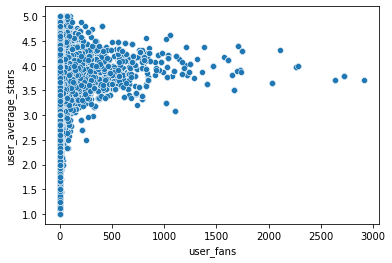

In [10]:
sns.scatterplot(x='user_fans', y='user_average_stars', data=df)

<AxesSubplot:xlabel='business_stars', ylabel='review_stars'>

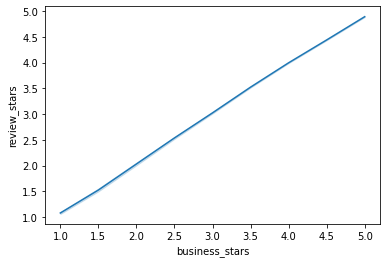

In [12]:
sns.lineplot(x='business_stars', y='review_stars', data=df)

In [14]:
df["review_stars"].unique()

array([5, 1, 4, 3, 2], dtype=int64)

<AxesSubplot:xlabel='review_stars', ylabel='size'>

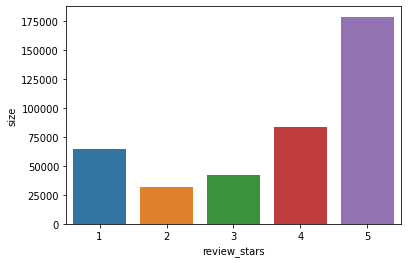

In [15]:
review_star_freq = df.groupby("review_stars", as_index=False).size()
sns.barplot(x="review_stars", y="size", data=review_star_freq)

Most users would like to give a high quality. Perhaps users may be more likely to write a comment and give stars when they had a good service

In [19]:
df["to_recommend"] = df["review_stars"].apply(lambda x : True if x == 5 else False)

<AxesSubplot:xlabel='business_stars', ylabel='to_recommend'>

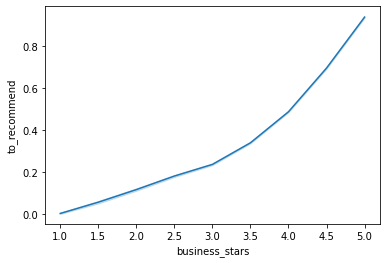

In [21]:
sns.lineplot(x='business_stars', y='to_recommend', data=df)

In [26]:
def num_user_friends(data):
    return data.count(',') + 1 if data != 'None' else 0

df["num_user_friends"] = df["user_friends"].apply(num_user_friends)

In [27]:
df.head(1)

,review_id,user_id,business_id,review_stars,review_text,review_text_after_cleaning,user_review_count,user_elite,user_friends,user_fans,user_average_stars,user_total_compliments,business_name,business_categories,business_stars,to_recommend,num_user_friends
0,yNB39szX3M8mTEzTtsgoCw,Y1iCYGvLf4ifPoXlKLGq-w,o2Qh4SiGYJ7BK4hP7dfkrw,5,This is an amazing indian Bistro!!I If I do sa...,amaz bistroi say myself never cuisin glad expe...,1,0,None,0,5.0,0,Saffron Indian Bistro,"Restaurants, Indian",4.5,True,0


In [28]:
df.to_csv("data/yelp_academic_dataset_sample005_filter.csv", index=False)

### Feature Engineering 

In [11]:
df.head(1)

,review_id,user_id,business_id,review_stars,review_text,review_text_after_cleaning,user_review_count,user_elite,user_friends,user_fans,user_average_stars,user_total_compliments,business_name,business_categories,business_stars
0,yNB39szX3M8mTEzTtsgoCw,Y1iCYGvLf4ifPoXlKLGq-w,o2Qh4SiGYJ7BK4hP7dfkrw,5,This is an amazing indian Bistro!!I If I do sa...,amaz bistroi say myself never cuisin glad expe...,1,0,,0,5.0,0,Saffron Indian Bistro,"Restaurants, Indian",4.5


In [12]:
es = ft.EntitySet("yelp")
es = es.entity_from_dataframe(entity_id = 'review', dataframe = df, index = 'review_id')
# The following commented codes can be used for the raw dataset
# es = es.entity_from_dataframe(entity_id = 'user', dataframe = user, index = 'user_id')
# es = es.entity_from_dataframe(entity_id = 'review', dataframe = review, index = 'review_id')
# es = es.entity_from_dataframe(entity_id = 'tip', dataframe = tip, index = 'user_id')
# es = es.entity_from_dataframe(entity_id = 'business', dataframe = business, index = 'business_id')
# es = es.entity_from_dataframe(entity_id = 'check_in', dataframe = check_in, index = 'business_id')
es

Entityset: yelp
  Entities:
    review [Rows: 400807, Columns: 15]
  Relationships:
    No relationships

In [13]:
features, feature_names = ft.dfs(entityset = es, target_entity = 'review', agg_primitives = ['mean', 'max', 'percent_true', 'last'])

In [14]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400807 entries, yNB39szX3M8mTEzTtsgoCw to 26iv0bQ5o3oxzZOSayQPjQ
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   user_id                                     400807 non-null  object 
 1   business_id                                 400807 non-null  object 
 2   review_stars                                400807 non-null  int64  
 3   user_review_count                           400807 non-null  int64  
 4   user_elite                                  400807 non-null  int64  
 5   user_fans                                   400807 non-null  int64  
 6   user_average_stars                          400807 non-null  float64
 7   user_total_compliments                      400807 non-null  int64  
 8   business_name                               400807 non-null  object 
 9   business_stars                        

In [15]:
features["NUM_CHARACTERS(user_friends)"]

review_id
yNB39szX3M8mTEzTtsgoCw       0
wxvs5Ih03vWCiJ6va1zJgw    1102
3GwovpioE5iXOmTqpdKCfQ       0
ipWXT0F2bE0smebUADaVRw     838
yJHS5HcNtSKG7X5pPseKIA    1006
                          ... 
uL2p8ifEXE58MoAUnwqBhA       0
dbZjuCnSGUJzogq9xcDIVQ       0
z5wUwHJzKOnIREamscek6w    2086
tERVb0iiv35MSXFZlUoHVw       0
26iv0bQ5o3oxzZOSayQPjQ    1438
Name: NUM_CHARACTERS(user_friends), Length: 400807, dtype: int64

In [ ]:
## TODO: Add something more on feature selection